# Fake Review Generation on the Yelp Dataset

More information on the Yelp dataset: https://www.yelp.com/dataset

In [ ]:
!python3 -V

Python 3.8.15


In [ ]:
!pip3 install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers
!pip install fastai==2.2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.3 MB/s eta 0:04:18tcmalloc: large alloc 1147494400 bytes == 0x39c5a000 @  0x7fac4cb1f615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0x49ced5
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:24tcmalloc: large alloc 1434370048 bytes == 0x7e2b0000 @  0x7fac4cb1f615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0x49ced5
     |█████

In [ ]:
import gc
import torch
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from fastai.text.all import *

In [ ]:
print(torch. __version__)

1.7.1+cu110


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
#!tar -xvf /content/drive/MyDrive/YelpDataset/yelp_dataset.tar

In [ ]:
!ls /content/drive/MyDrive/YelpDataset/dataframes

AutoDF.pkl		     HealthMedicalDF.pkl  restaurantDF.pkl
beautyandSpaDF.pkl	     HomeServicesDF.pkl   shoppingDF.pkl
EventPlanningServicesDF.pkl  LocalServicesDF.pkl
foodDF.pkl		     NightlifeDF.pkl


In [ ]:
#%cp /content/yelp_academic_dataset_review.json /content/drive/MyDrive/YelpDataset

In [ ]:
#%cp /content/drive/MyDrive/YelpDataset/yelp_academic_dataset_review.json /content/
%cp /content/drive/MyDrive/YelpDataset/dataframes/beautyandSpaDF.pkl /content/

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_pickle('beautyandSpaDF.pkl')

In [ ]:
df.shape

(282527, 15)

In [ ]:
#process the yelp dataset in similar fashion to the amazon review dataset.
#we'll only need the text coloumn in our case
df_main = df[['text']]

In [ ]:
df_main = df_main.rename(columns={'text': 'reviewText'})

In [ ]:
df_main.head(20)

,reviewText
98648,I have nothing but good things to say. Randy and the whole staff was professional and warm. I felt like I was working with people who cared about me and my results and not just $$$. I would highly recommend getting the free evaluation. They will work with you budget wise.
98649,"I've been going to Boise Therapeutic Massage for 4 years now. I'm giving it 5 stars because I can always get an appointment the day I call, every therapist is exceptional, and the price is reasonable. I've never been disappointed. It isn't a fancy spa but their clinic is relaxing and the staff makes you feel welcome and I go for the massage and not the spa experience anyway. I've started going to Amy exclusively for all my massages. It's wonderful when you find someone who knows where your trouble spots are and can make you feel human again."
98650,"Outstanding! I went to this place on the strength of just two Yelp reviews. Weary from being a traveling soccer mom for a week, I just wanted to be pampered for one hour in peace. When I found that I could get 90 minutes of massage therapy for $60 I thought ""how bad could this be?""\nBut I am telling you guys, this place is awesome. Nothing fancy, it is a modest space, more of a clinic than a spa. It is clean, quiet and they staff is super friendly. My therapist Marlene used body pillows and heated blankets to reposition me and to get into areas deep between my shoulder blades that most..."
98651,I came here about a month ago and I really like the atmosphere here and the friendly staff as well. They addressed my back issue that I have going on and they made me feel right at home. I really like it here and will be coming back very very aoon.
98652,Have been going there for several years now. They have really helped to keep my migraines under control. Nice and relaxing environment as well.
98653,Always good and relaxing. They have staffing that allows for same day appointments. Highly recommended
98654,"I came here after a 3 day backpacking trip and received one of the best, most thoughtful massages of my life from Summer. I wish I lived in the Boise area so I could go back for another! I had asked for hot stone and aromatherapy and Summer suggested adding cupping-and it was SO worth it. The perfect trifecta. I would recommend Summer to anyone!"
98655,"Clean, therapists were friendly and capable. The shared room is small and it's magic the work they get done in there. The front desk staff is at best just there to collect a paycheck and at worst just a really apathetic slightly less than nice person. Overall the pricing is fair and the place is clean."
98656,"I made an appointment for one hour. I was on the table for 75 minutes. The masseuse must not have known how long the appointment was for, or perhaps she didn't care? The front desk charged me for 90 minutes. Next time, if there is a next time, I will remind the masseuse how long my appointment is for before we begin. The massage itself was good. I've had better. I've had worse."
98657,"I would give this place 6 stars if I could. I'm almost 6 mo. pregnant and my husband and I drove up from Los Angeles. The long drive in combination with sleeping in different beds every night for the past few days caused me to have sciatic issues and numb arms that I'd never felt in before. I had seen a chiropractor a couple days before when we were in Portland, but I was still in pain and couldn't sleep at night. I was miserable, on the verge of tears! \n\nI found this place through Yelp and called as soon as I arrived in Boise. They were able to schedule an appointment for me within ..."


In [ ]:
df_main.shape

(282527, 1)

In [ ]:
#sample_size = len(df_main)

In [ ]:
#we sample 100,000 since we sampled 5% for restaurants which gave us around 188k samples
sample_df = df_main.sample(n=100000, random_state=2021).dropna().reset_index()

In [ ]:
sample_df.dtypes

index          int64
reviewText    object
dtype: object

In [ ]:
del df_main
gc.collect()

26659

In [ ]:
sample_df.shape

(100000, 2)

In [ ]:
#Let's import the pretrained GPT2 model and the tokenizers
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [ ]:
device = torch.device("cuda")

In [ ]:
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_train, df_valid = train_test_split(sample_df, random_state=2021, test_size=0.1)

In [ ]:
all_texts = np.concatenate([df_train["reviewText"].values, df_valid["reviewText"].values])

In [ ]:
all_texts.shape

(100000,)

In [ ]:
e = 0
toRemove = []
for i in range(len(all_texts)):
  if all_texts[i]=="":
    e+=1
    print(f"all_texts[{i}] is empty")
    all_texts[i] = 'a'
    toRemove.append(i)

print(f"Number of rows that are empty={e}. To remove indecies={toRemove}")

Number of rows that are empty=0. To remove indecies=[]


In [ ]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [ ]:
splits = [list(df_train.index), list(df_valid.index)]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [ ]:
"""e = 0
for i in range(len(tls.train)):
  if tls.train[i].type() != 'torch.LongTensor':
    #print(f'tls.train[{i}] not a long tensor')
    #print(f'tls.train[{i}] is a {tls.train[i].type()}')
    e+=1
print("Total of e=",e," empty")"""

'e = 0\nfor i in range(len(tls.train)):\n  if tls.train[i].type() != \'torch.LongTensor\':\n    #print(f\'tls.train[{i}] not a long tensor\')\n    #print(f\'tls.train[{i}] is a {tls.train[i].type()}\')\n    e+=1\nprint("Total of e=",e," empty")'

In [ ]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([139]), torch.Size([135]))

In [ ]:
show_at(tls.train, 0)

Heather Happy is amazing! I can't say enough wonderful things about my experience! 
I knew the result I wanted, but didn't know how to get there. I was full of questions and Heather had the answers. She was very knowledgeable and patient as she sat through my rant of questions.
Heather went into detail about my different options and their outcomes, and together we decided which treatment was right for me. 
The treatment was quick and efficient. Easy-peasy as they say. The recovery  was just as she described, and my post treatment questions were answered quickly.
Her knowledge of skincare is a huge bonus and my skin never looked better!


In [ ]:
show_at(tls.valid, 0)

Great staff and wonderful experience. I have suffered from chronic pain, DDD, and sciatica for several years now. Already feeling worlds better after my hubby treated me to one of their bombshell packages this afternoon. We're from out of town and wasn't sure where to go, but this place is definitely worth checking out. Very friendly and personable staff. The services  were all top notch. Nakesha was my estetician (she did my foot treatment and facial) and Skyler did my hour massage. I highly recommend if you need a good day of pampering/relaxation and will be seeing them again next time in town!


In [ ]:
bs,sl = 4,200
dls = tls.dataloaders(bs=bs, seq_len=sl, device=device)

Token indices sequence length is longer than the specified maximum sequence length for this model (1106 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
dls.show_batch(max_n=2)

,text,text_
0,"Wonderful! It was a very busy day at the salon and I was a 1/2 hr early, but I was never forgotten. Malika is a master at multitasking and a joy to be around! Ms. Kay cut my hair and she was very patient with me! I have short hair and I can be particular, Ms. Kay was open to changes I requested and even made wonderful improvements.\nIn addition, Malika fit in time to do a color patch test, I have extremely sensitive skin and haven't been able to dye my hair for almost 10 years. My hope was that with their organic process this may be a possibility again, and I am pleased to say that it is.\nThe pricing is outstanding, even without the groupon that I had, $8 to get my brows waxed, and again, Malika did them exactly the way I like, nice and thick!\nI","ful! It was a very busy day at the salon and I was a 1/2 hr early, but I was never forgotten. Malika is a master at multitasking and a joy to be around! Ms. Kay cut my hair and she was very patient with me! I have short hair and I can be particular, Ms. Kay was open to changes I requested and even made wonderful improvements.\nIn addition, Malika fit in time to do a color patch test, I have extremely sensitive skin and haven't been able to dye my hair for almost 10 years. My hope was that with their organic process this may be a possibility again, and I am pleased to say that it is.\nThe pricing is outstanding, even without the groupon that I had, $8 to get my brows waxed, and again, Malika did them exactly the way I like, nice and thick!\nI"
1,"Barbara two and a half years ago and since have been driving 6 1/2 hours to get my hair done in my hometown. I am soooo glad I decided to book an appointment at Patine! The receptionist was very friendly and was able to book an appointment for me with Danica for the following day! I'm in the process of growing my hair out after cutting it all off for a backpacking trip. The back had grown into a horrible mullet that had to go! Danica was so welcoming right off the bat and put my nerves to ease! She did such an amazing job, not cutting any more than she needed to! The cut looks absolutely amazing! I will be back! Thank you Danica!My mom and I have had our nails done by Daisy (owner) for 15+ years. I moved away from Nashville 10 years ago and a","two and a half years ago and since have been driving 6 1/2 hours to get my hair done in my hometown. I am soooo glad I decided to book an appointment at Patine! The receptionist was very friendly and was able to book an appointment for me with Danica for the following day! I'm in the process of growing my hair out after cutting it all off for a backpacking trip. The back had grown into a horrible mullet that had to go! Danica was so welcoming right off the bat and put my nerves to ease! She did such an amazing job, not cutting any more than she needed to! The cut looks absolutely amazing! I will be back! Thank you Danica!My mom and I have had our nails done by Daisy (owner) for 15+ years. I moved away from Nashville 10 years ago and a good"


### Fine Tuning 

In [ ]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [ ]:
learn.validate()

(#2) [3.7659335136413574,43.204017639160156]

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.14454397559165955)

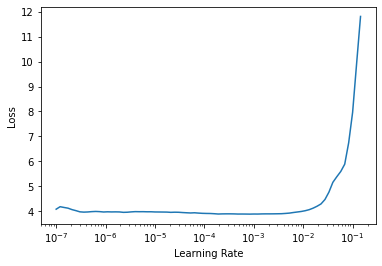

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,perplexity,time
0,3.237270,3.194633,24.401222,42:51


A perplexity of 100 means that whenever the model is predicting the next word, the model is as confused as if it had to pick between 100 different words

In [ ]:
#save model weights. Commented out since we don't need it now
learn.save("gpt2-finetuned-yelp-reviews-sample-1cycle-BeautySpa")

Path('models/gpt2-finetuned-yelp-reviews-sample-1cycle-BeautySpa.pth')

In [ ]:
%cp /content/models/gpt2-finetuned-yelp-reviews-sample-1cycle-BeautySpa.pth /content/drive/MyDrive/YelpDataset/models

In [ ]:
df_valid.head(1)

,index,reviewText
23307,514998,"I went to innovate for a facial and saw Elissa. She was amazing! Everyone there is super friendly and professional. I really liked how thorough elissa was with me, you can tell that she really cares about your needs when performing a service. I'll definitely be going back!"


### Review Example 1

In [ ]:
prompt = "Bad service"

In [ ]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 2])

In [ ]:
preds = learn.model.generate(inp, max_length=70, num_beams=5, temperature=0.75, early_stopping=True, no_repeat_ngram_size=2)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
tokenizer.decode(preds[0].cpu().numpy())

"Bad service. I went in for a pedicure and a gel manicure. The lady who did my nails was very nice and did a great job. However, I had to wait a while to get my pedi done because I was in a rush and she didn't even bother to clean up my cuticles. When I got home,"

### Review Example 2



In [ ]:
prompt = "The spa was okay"

In [ ]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 4])

In [ ]:
preds = learn.model.generate(inp, max_length=100, num_beams=5, temperature=0.75, early_stopping=True, no_repeat_ngram_size=2)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
tokenizer.decode(preds[0].cpu().numpy())

"The spa was okay, but I will not be returning.I've been going to this salon for about a year now and have never had a bad experience. The staff is very friendly and the salon is always clean. I've had my nails done here a few times and they always do a great job. However, the last time I went, I got a gel manicure and a regular pedicure. My nails were not filed evenly and I had to ask her to file them down a"

### Review Example 3



In [ ]:
prompt = "Ken Knox created such bad vibe "

In [ ]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 7])

In [ ]:
preds = learn.model.generate(inp, max_length=60, num_beams=20, temperature=0.75, early_stopping=True, no_repeat_ngram_size=2, top_k=100)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
tokenizer.decode(preds[0].cpu().numpy())

'Ken Knox created such bad vibe  from the moment I walked in the door. \n\nI went in for a full set of acrylics and a pedicure. The lady who did my nails was very nice and did a great job. She took her time and made sure I was happy'

### Review Example 4



In [ ]:
prompt = "I came here about a month ago and I really like the massage"

In [ ]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 13])

In [ ]:
preds = learn.model.generate(inp, max_length=70, num_beams=4, temperature=0.75, early_stopping=True, no_repeat_ngram_size=3)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
tokenizer.decode(preds[0].cpu().numpy())

"I came here about a month ago and I really like the massage therapists. I've had a lot of massages in the past and this was by far the best one I've ever had. The staff is very friendly and the facility is very clean. I would definitely recommend this place to anyone looking for a great massage.I have been going to"